In [12]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

In [13]:
c = 3.0*1e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
#R = 75e-9  # particle radius (m)
R = 80*1e-9
T = 297 # K
lamb = 1064*1e-9  # (m)
NA = 0.13159027319676828
P = 1000*1e-3 # Total Power (W), and here I'm considering that the two beams are of same power, half of P actually
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (=1 atm)
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
m_rri = n_p/n_md #relative refractive index
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [14]:
w_0=2.9250000000000004e-06

In [15]:
N = 200_000_000
dt = 1e-9

In [16]:
beta = 1e6 #freq acceleration #Hz/s**2 ?
#delta_omega=1e5

@njit(fastmath=True)
def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

@njit(fastmath=True)
def F_opt(x,y,z,t):
    alpha_fac = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))
    F_0 = (P/(2*np.pi*(w_0**2)))*alpha_fac

    exp_term = np.exp(-2 * (x**2 + y**2) / (w_0**2))
    cos_term = np.cos(np.remainder(2 * k * z - beta * t**2, 2*np.pi))
    sin_term = np.sin(np.remainder(2 * k * z - beta * t**2, 2*np.pi))

    fx = F_0*((-4 * x / w_0**2) * exp_term * cos_term)
    fy = F_0*((-4 * y / w_0**2) * exp_term * cos_term)
    fz = F_0*(-2 * k * exp_term * sin_term)

    return fx, fy, fz

@njit(fastmath=True)
def P_grad(pos):
    z_max = 8*1e-3

    Pi = 100
    Pf = 1e-8
    return Gamma_env(Pi + ((Pf-Pi)/z_max)*pos)

@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos,F_total_z,v,gamma_hz):
    return F_total_z/m - gamma_hz*v

In [17]:
#fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharey=True)
#
#x_ax = np.linspace(-5e-6, 5e-6, 1_000_000)
#y_ax = np.linspace(-5e-6, 5e-6, 1_000_000)
#z_ax = np.linspace(-5e-6, 5e-6, 1_000_000)
#
#axs[0].plot(x_ax*1e6,F_opt(x_ax,0,0,0)[0]*1e12)
#axs[0].set_xlabel(r'$x\ \left[\mu\mathrm{m}\right]$')
#axs[0].grid(True)
#axs[0].set_xlim(-5,5)
#axs[0].set_ylim(-0.6,0.6)
#axs[0].set_ylabel(r'Force $\left[\mathrm{pN}\right]$')
#
#axs[1].plot(y_ax*1e6,F_opt(0,y_ax,0,0)[1]*1e12)
#axs[1].set_xlabel(r'$y\ \left[\mu\mathrm{m}\right]$')
#axs[1].grid(True)
#axs[1].set_xlim(-5,5)
#
#axs[2].plot(z_ax*1e6,F_opt(0,0,z_ax,0)[2]*1e12)
#axs[2].set_xlabel(r'$z\ \left[\mu\mathrm{m}\right]$')
#axs[2].grid(True)
#axs[2].set_xlim(0,1)
#
#plt.tight_layout()
#plt.show()

In [18]:
@njit(fastmath=True)
def runge_kutta(v_init, pos_init):
    positions = np.zeros((N, 3))
    velocities = np.zeros((N, 3))
    
    positions[0, :] = pos_init
    velocities[0, :] = v_init

    for i in range(N - 1):
        Fs = np.array(F_opt(positions[i, 0], positions[i, 1], positions[i, 2], dt * i))
        
        gamma_hz = P_grad(positions[i, 2])

        k1_pos = velocities[i] * dt
        k1_v = np.array([dv_dt(positions[i, j], Fs[j], velocities[i, j], gamma_hz) for j in range(3)]) * dt

        k2_pos = (velocities[i] + 0.5 * k1_v) * dt
        k2_v = np.array([dv_dt(positions[i, j] + 0.5 * k1_pos[j], Fs[j], velocities[i, j] + 0.5 * k1_v[j], gamma_hz) for j in range(3)]) * dt

        k3_pos = (velocities[i] + 0.5 * k2_v) * dt
        k3_v = np.array([dv_dt(positions[i, j] + 0.5 * k2_pos[j], Fs[j], velocities[i, j] + 0.5 * k2_v[j], gamma_hz) for j in range(3)]) * dt

        k4_pos = (velocities[i] + k3_v) * dt
        k4_v = np.array([dv_dt(positions[i, j] + k3_pos[j], Fs[j], velocities[i, j] + k3_v[j], gamma_hz) for j in range(3)]) * dt

        positions[i + 1] = positions[i] + (1.0 / 6.0) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
        velocities[i + 1] = velocities[i] + (1.0 / 6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

        thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal(0, 1, 3) * np.sqrt(dt) / m
        velocities[i + 1] += thermal_noise

    return positions, velocities

In [ ]:
x0 = np.array([0.0, 0.0, 0.0]) #(dt)*np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
v0 = np.array([0.0, 0.0, 0.0]) #np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m

positions, velocities = runge_kutta(v0,x0)

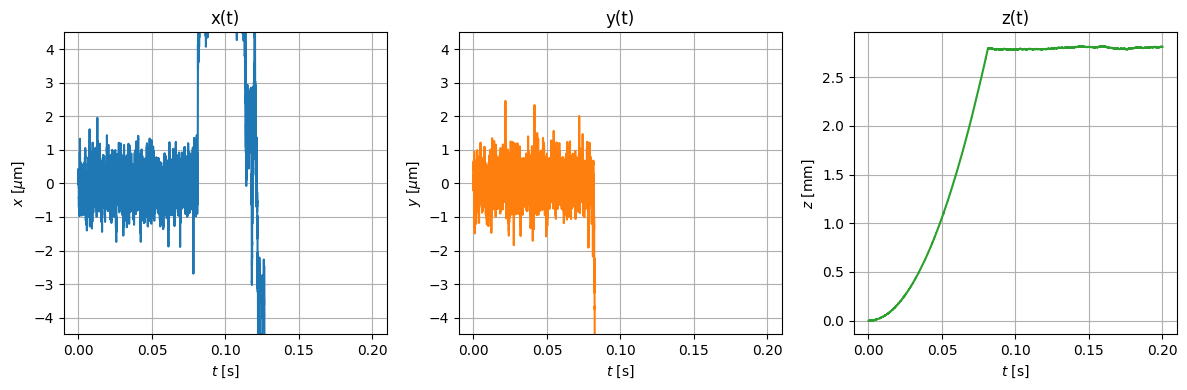

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
l = 0

t = np.arange(N)*dt

axs[0].plot(t[::100], positions[::100,0] * 1e6, color='#1f77b4')
axs[0].set_ylim(-4.5, 4.5)
axs[0].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[0].set_ylabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].set_title("x(t)")
axs[0].grid(True)

axs[1].plot(t[::100], positions[::100,1] * 1e6, color='#ff7f0e')
axs[1].set_ylim(-4.5, 4.5)
axs[1].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[1].set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].set_title("y(t)")
axs[1].grid(True)

axs[2].plot(t[::100], positions[::100,2]*1e3, color='#2ca02c')
#axs[2].set_ylim(-1e-3, 1e-1)
axs[2].set_xlabel(r'$t\ \left[\mathrm{s}\right]$')
axs[2].set_ylabel(r'$z\ \left[\mathrm{mm}\right]$')
axs[2].set_title("z(t)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

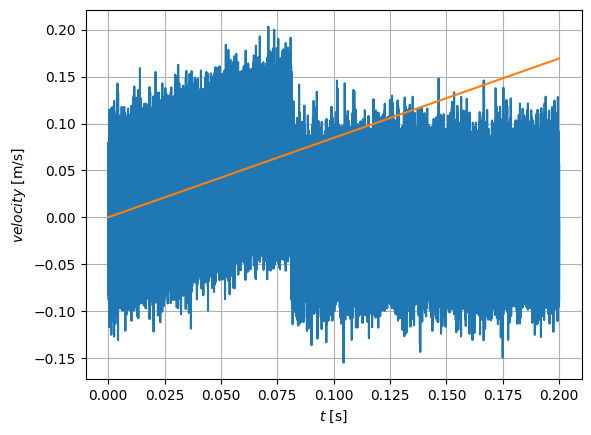

In [ ]:
vz = np.gradient(positions[:, 2], dt)

v_max = np.max(np.abs(vz))
velocidade_final = (beta*dt*N)/(2*k)

#print(f'Maximum velocity of the lattice: {velocidade_final:.3e} m/s')
#print(f'Maximum velocity of the particle: {v_max*1e3:.3e} mm/s')
plt.plot(t[::100],vz[::100])
plt.plot(t[::100],((beta*t)/(k))[::100])


plt.ylabel(r'$velocity\ \left[\mathrm{m/s}\right]$')
plt.xlabel(r'$t\ \left[\mathrm{s}\right]$')
plt.grid(True)
plt.show()

In [ ]:
alpha = 3*volume*epsilon_0*(((m_rri**2)-1)/((m_rri**2)+2))
E_2 = 4*P/(np.pi*(w_0**2)*epsilon_0*c)
q = 2*k
a = (1/2)*alpha*q*E_2/m

print((2*beta)/(a*q))

6.50777012841853e-07
